In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

#### 데이터 준비

In [4]:
df_iris = pd.read_csv('data/iris.csv').iloc[:,1:]
df_iris.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### 데이터 전처리

#### target 인코딩

In [5]:
# ----------------
# target 인코딩
# ----------------
class_names = {'Iris-setosa':0,
               'Iris-versicolor':1,
               'Iris-virginica':2}
df_iris['target'] = df_iris['Species'].map(class_names)

#### 데이터 선택

In [6]:
# ----------------
# X, y
# ----------------
X = df_iris.drop(['Species', 'target'], axis=1)
y = df_iris['target']

#### 학습용 데이터와 테스트용 데이터 분할

In [7]:
# ----------------
# 균등분할
#   stratify
# ----------------

from sklearn.model_selection import train_test_split

# 학습용 데이터와 테스트용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size=0.2
                                                    , random_state=42
                                                    , stratify=y)

# 데이터의 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(120, 4) (30, 4) (120,) (30,)


### 그리드서치

#### 모델 생성

In [ ]:
# ---------------------------------------
# DecisionTreeClassifier 모델 생성
# ---------------------------------------
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)


,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': [3, 4, ...], 'min_samples_split': [2, 4]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


#### KFold 객체 생성

In [ ]:
# ---------------------------------------
# StratifiedKFold 객체 생성
# ---------------------------------------
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#### 하이퍼파리미터 준비

In [14]:
# -----------------------------
# 하이퍼파라미터 준비
# -----------------------------
parameters = {'max_depth':[3,4,5],
              'min_samples_split':[2,4]}

#### GridSearchCV 객체 생성

In [16]:
# -----------------------------
# GridSearchCV 객체 생성
# -----------------------------
from sklearn.model_selection import GridSearchCV
gscv = GridSearchCV(model, 
                    param_grid=parameters, 
                    cv=skf, 
                    refit=True)

#### GridSearchCV로 학습/평가

In [17]:
# -----------------------------
# 하이퍼파라미터를 순차적으로 변경하면서 학습/평가 수행
# -----------------------------
gscv.fit(X_train, y_train)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': [3, 4, ...], 'min_samples_split': [2, 4]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


#### 결과 확인

In [18]:
# -----------------------------
# 그리드서치 결과 확인
# -----------------------------
results = pd.DataFrame(gscv.cv_results_)
print('best_params',gscv.best_params_)
print('best_score',gscv.best_score_)
results.head(3)

best_params {'max_depth': 3, 'min_samples_split': 2}
best_score 0.9583333333333334


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003127,0.000493,0.001722,0.000410,3,2,"{'max_depth': 3, 'min_samples_split': 2}",0.958333,1.000000,0.958333,0.958333,0.916667,0.958333,0.026352,1
1,0.002882,0.000861,0.001504,0.000638,3,4,"{'max_depth': 3, 'min_samples_split': 4}",0.958333,1.000000,0.958333,0.958333,0.916667,0.958333,0.026352,1
2,0.001982,0.001103,0.001811,0.000682,4,2,"{'max_depth': 4, 'min_samples_split': 2}",0.958333,0.958333,0.958333,0.916667,0.916667,0.941667,0.020412,6


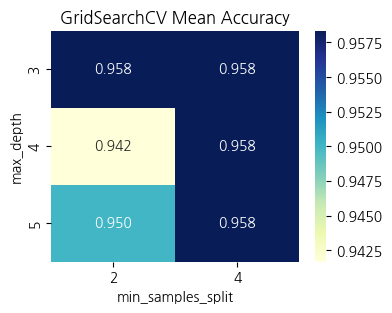

In [19]:
pivot_table = results.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_min_samples_split'
)

plt.figure(figsize=(4, 3))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("GridSearchCV Mean Accuracy")
plt.ylabel("max_depth")
plt.xlabel("min_samples_split");

#### 최종 모델 

In [20]:
# -----------------------------
# 최종모델
# -----------------------------
best_model = gscv.best_estimator_


#### 테스트세트로 최종 테스트

In [22]:
# -----------------------------
# 최종 테스트
# -----------------------------
pred = best_model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



### 전체 데이터로 최종모델 재학습(선택적)